# CIFAR-100 Dataset: Image Classification
## Nick Cantalupa and Sean Duffy
In this project, we will be training 4 seperate models useing different supervised machine learning techniques. These models will be classifying images using a dataset of 60,000 training images. 

## Loading dataset

In [90]:
import torch
from torchvision.datasets import CIFAR100, CIFAR10
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [98]:
ROOT_PATH = 'data'

BATCH_SIZE = 500

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR100(root=ROOT_PATH, download=True, train=True, transform=transform)
eval_dataset = CIFAR100(root=ROOT_PATH, train=False, transform=transform)

train_data_loader = DataLoader(dataset=train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
eval_data_loader = DataLoader(dataset=eval_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [39]:
import json

with open('data/cifar-100-python/meta', 'rb') as file:
    meta = pickle.load(file)

with open("labels.json", 'w') as mf:
    json.dump(meta, mf)

In [40]:
label_mapper = {}
for i , label in enumerate(meta["fine_label_names"]):
    label_mapper[i] = label

In [41]:
for train_data, train_labels in train_data_loader:
    print(train_data.shape)
    print(train_labels.shape)
    break

for eval_data, eval_labels in eval_data_loader:
    print(eval_data.shape)
    print(eval_labels.shape)
    break

torch.Size([50000, 3, 32, 32])
torch.Size([50000])
torch.Size([10000, 3, 32, 32])
torch.Size([10000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


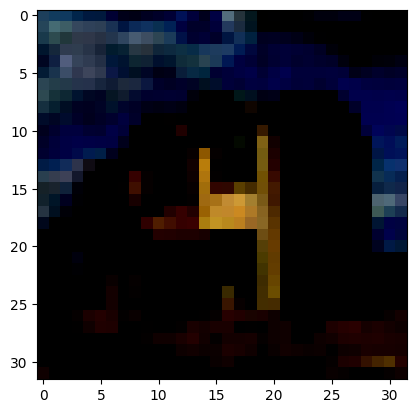

house


In [43]:
i = 379
img = train_data[i, :].permute(1,2,0)
plt.imshow(img)
plt.show()
print(label_mapper[int(train_labels[i])])

In [30]:
train_data[0].shape

torch.Size([3, 32, 32])

## Logistic Regression

We do not expect Logistic Regression to be a great application of ML in this scenario but it will be good to check the accuracy and see how we can tune it a little bit to improve results.

We first are going to convert the Tensor of data into 2 dimensions so we can run Logistic regression on it for training the model.

In [34]:
def flatten(img_tensor):
    flattened_data = []
    for i in range(len(img_tensor)):
        if (i%1000 == 0):
            print(round((i/len(img_tensor))*100, 4),"%", end= "\r")
        flat = img_tensor[i].flatten()
        flat = flat.numpy()
        flattened_data.append(pd.Series(flat))

    return pd.DataFrame(flattened_data)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [47]:
X_train = flatten(train_data)
y_train = train_labels

X_eval = flatten(eval_data)
y_eval = eval_labels

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=300)
lr_model.fit(X_train, y_train)

/Users/ncantalupa/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, multi_class='multinomial')

In [48]:
y_pred = lr_model.predict(X_eval)
eval_accuracy = accuracy_score(y_eval, y_pred)
print("Accuracy:", eval_accuracy)

Accuracy: 0.1348


This is a decent accuracy given that Logisitic Regression is not meant to handle this many classes effectively. Since this model hit the max iterations, we will see if performing PCA on it to reduce dimensinoality can improve the performance. We can do this since we saw above that the xplained variance stays very high after reducing dimensions significantly. This should help speed up our algorithm and make it easier to run. 

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(random_state=41)
scaler = StandardScaler()
X_train_reduced = pca.fit_transform(scaler.fit_transform(X_train))
X_train_reduced = X_train_reduced[:,:250]
X_eval_reduced = pca.transform(X_eval)
X_eval_reduced = X_eval_reduced[:,:250]

In [59]:
lr_reduced_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_reduced_model.fit(X_train_reduced, y_train)

/Users/ncantalupa/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [60]:
y_reduced_pred = lr_reduced_model.predict(X_eval_reduced)
eval_accuracy = accuracy_score(y_eval, y_reduced_pred)
print("Accuracy:", eval_accuracy)

Accuracy: 0.1523


This PCA reduction slightly helped out the model and increases the accuracy to 15%. This is still not great but this is about what you can expect for a regression that focuses on binary classification. With CIFAR 100 this is still a good improvement from the baseline but we can hopefully increase our accuracy with other algorithms. 